In [1]:
# https://github.com/zjysteven/VLM-Visualizer/tree/main

In [1]:
import os
import sys
# sys.path.append("./models")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
# pip install opencv-python
from PIL import Image

import torch
import torch.nn.functional as F

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path


/raid_sdb/home/whz/miniforge3/envs/halle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-02-18 03:15:14,385] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [ ]:
# many are copied from https://github.com/mattneary/attention/blob/master/attention/attention.py
# here it nullifies the attention over the first token (<bos>)
# which in practice we find to be a good idea
from io import BytesIO
from PIL import Image
import requests
import torch
import numpy as np
import cv2


def aggregate_llm_attention(attn):
    '''Extract average attention vector'''
    avged = []
    for layer in attn:
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = torch.concat((
            # We zero the first entry because it's what's called
            # null attention (https://aclanthology.org/W19-4808.pdf)
            torch.tensor([0.]),
            # usually there's only one item in attns_per_head but
            # on the first generation, there's a row for each token
            # in the prompt as well, so take [-1]
            attns_per_head[-1][1:].cpu(),
            # attns_per_head[-1].cpu(),
            # add zero for the final generated token, which never
            # gets any attention
            torch.tensor([0.]),
        ))
        avged.append(vec / vec.sum())
    return torch.stack(avged).mean(dim=0)


def aggregate_vit_attention(attn, select_layer=-2, all_prev_layers=True):
    '''Assuming LLaVA-style `select_layer` which is -2 by default'''
    if all_prev_layers:
        avged = []
        for i, layer in enumerate(attn):
            if i > len(attn) + select_layer:
                break
            layer_attns = layer.squeeze(0)
            attns_per_head = layer_attns.mean(dim=0)
            vec = attns_per_head[1:, 1:].cpu() # the first token is <CLS>
            avged.append(vec / vec.sum(-1, keepdim=True))
        return torch.stack(avged).mean(dim=0)
    else:
        layer = attn[select_layer]
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)
        vec = attns_per_head[1:, 1:].cpu()
        return vec / vec.sum(-1, keepdim=True)


def heterogenous_stack(vecs):
    '''Pad vectors with zeros then stack'''
    max_length = max(v.shape[0] for v in vecs)
    return torch.stack([
        torch.concat((v, torch.zeros(max_length - v.shape[0])))
        for v in vecs
    ])


def load_image(image_path_or_url):
    if image_path_or_url.startswith('http://') or image_path_or_url.startswith('https://'):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path_or_url).convert('RGB')
    return image


def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_HSV)
    hm = np.float32(heatmap) / 255
    cam = hm + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam), heatmap

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


def process_images(images, image_processor, model_cfg):
    image_aspect_ratio = getattr(model_cfg, "image_aspect_ratio", None)
    new_images = []
    new_raw_images = []
    if image_aspect_ratio == 'pad':
        for image in images:
            image = expand2square(image, tuple(int(x*255) for x in image_processor.image_mean))
            new_raw_images.append(image)
            image = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
            new_images.append(image)
    else:
        return image_processor(images, return_tensors='pt')['pixel_values']
    if all(x.shape == new_images[0].shape for x in new_images):
        new_images = torch.stack(new_images, dim=0)
    return new_images, new_raw_images

In [3]:
# ===> specify the model path
model_path = "/raid_sdd/whz/model/llava_v1_5_7b"

# load the model
load_8bit = False
load_4bit = False
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda:1")

disable_torch_init()

model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, 
    None, # model_base
    model_name, 
    load_8bit, 
    load_4bit, 
    device_map=device
)

LlavaConfig {
  "_name_or_path": "/raid_sdd/whz/model/llava_v1_5_7b",
  "architectures": [
    "LlavaLlamaForCausalLM"
  ],
  "attention_bias": false,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "freeze_mm_mlp_adapter": false,
  "freeze_mm_vision_resampler": false,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "image_aspect_ratio": "pad",
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_length": 4096,
  "max_position_embeddings": 4096,
  "mm_hidden_size": 1024,
  "mm_projector_type": "mlp2x_gelu",
  "mm_resampler_type": null,
  "mm_use_im_patch_token": false,
  "mm_use_im_start_end": false,
  "mm_vision_select_feature": "patch",
  "mm_vision_select_layer": -2,
  "mm_vision_tower": false,
  "model_type": "llava",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float

Loading checkpoint shards: 100%|██████████| 2/2 [00:59<00:00, 29.75s/it]


In [4]:
print(model.device)
model = model.to(device)

cuda:1


llava_v1_5_7b
llava_v1


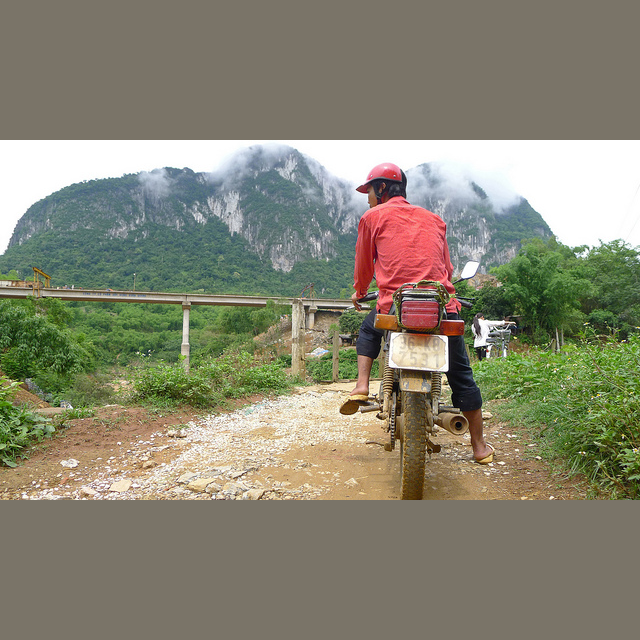

How many people in the image?


In [68]:
# ===> specify the image path or url and the prompt text
# image_path_or_url = "https://github.com/open-compass/MMBench/blob/main/samples/MMBench/1.jpg?raw=true"
# prompt_text = "What python code can be used to generate the output in the image?"
image_path_or_url = "/home/whz/code/HallE/llava/serve_images/COCO_val2014_000000391895.jpg"
# prompt_text = "What is the man doing?"
# prompt_text = "Describe the image in detail."
prompt_text = "How many people in the image?"

################################################
# preparation for the generation
# unlikely that you need to change anything here
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

print(model_name)
print(conv_mode)

conv = conv_templates[conv_mode].copy()
if "mpt" in model_name.lower():
    roles = ('user', 'assistant')
else:
    roles = conv.roles

image = load_image(image_path_or_url)
image_tensor, images = process_images([image], image_processor, model.config)
image = images[0]
image_size = image.size
if type(image_tensor) is list:
    image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(model.device, dtype=torch.float16)

if model.config.mm_use_im_start_end:
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + prompt_text
else:
    inp = DEFAULT_IMAGE_TOKEN + '\n' + prompt_text

conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
# manually removing the system prompt here
# otherwise most attention will be somehow put on the system prompt
prompt = prompt.replace(
    "A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. ",
    ""
)

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)

################################################

display(image)
print(prompt_text)

In [69]:
# generate the response
with torch.inference_mode():
    outputs = model.generate(
        input_ids,
        images=image_tensor,
        do_sample=False,
        max_new_tokens=512,
        use_cache=True,
        return_dict_in_generate=True,
        output_attentions=True,
    )

In [70]:
# text = tokenizer.decode(outputs["sequences"][0]).strip()
output_ids = outputs['sequences'][0]

input_token_len = input_ids.shape[1]
text = tokenizer.decode(output_ids[input_token_len:], skip_special_tokens=True)

print(text)

There is only one person in the image, a man riding a motorcycle.


Below we are aggregating LLM's attention aross heads and layers (simply averaging them). See the `aggregate_llm_attention` in `utils.py` for details. 

In [71]:
# constructing the llm attention matrix
aggregated_prompt_attention = []
for i, layer in enumerate(outputs["attentions"][0]):
    layer_attns = layer.squeeze(0)
    attns_per_head = layer_attns.mean(dim=0)
    cur = attns_per_head[:-1].cpu().clone()
    # following the practice in `aggregate_llm_attention`
    # we are zeroing out the attention to the first <bos> token
    # for the first row `cur[0]` (corresponding to the next token after <bos>), however,
    # we don't do this because <bos> is the only token that it can attend to
    cur[1:, 0] = 0.
    cur[1:] = cur[1:] / cur[1:].sum(-1, keepdim=True)
    aggregated_prompt_attention.append(cur)
aggregated_prompt_attention = torch.stack(aggregated_prompt_attention).mean(dim=0)

# llm_attn_matrix will be of torch.Size([N, N])
# where N is the total number of input (both image and text ones) + output tokens
llm_attn_matrix = heterogenous_stack(
    [torch.tensor([1])]
    + list(aggregated_prompt_attention) 
    + list(map(aggregate_llm_attention, outputs["attentions"]))
)

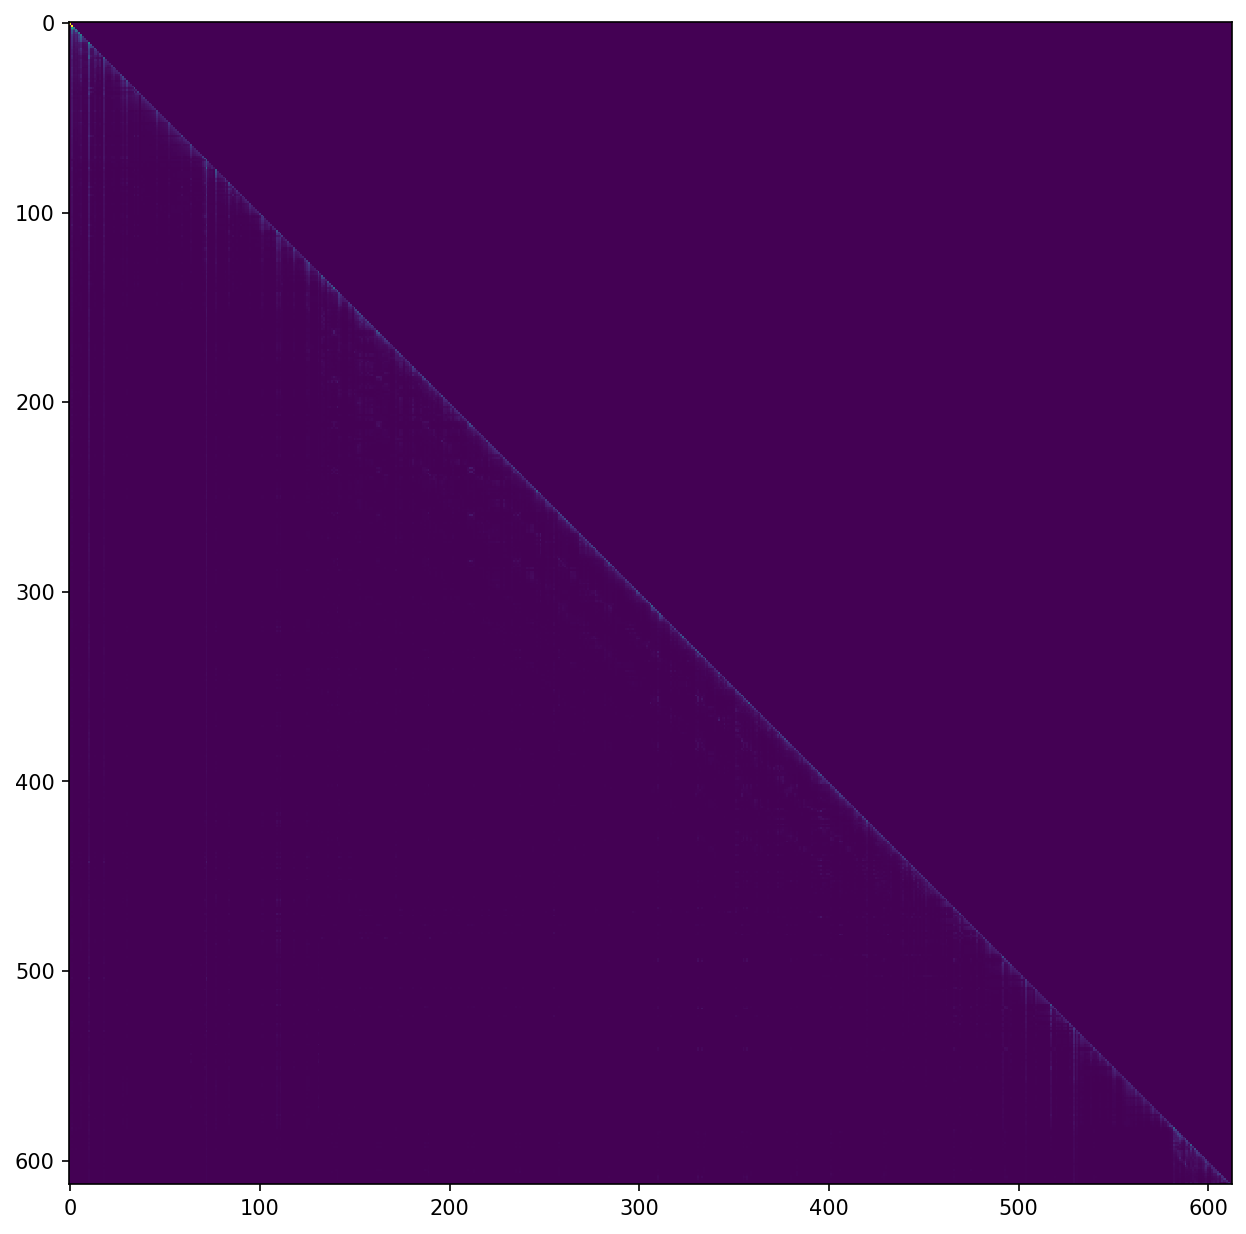

In [72]:
# visualize the llm attention matrix
# ===> adjust the gamma factor to enhance the visualization
#      higer gamma brings out more low attention values
gamma_factor = 1
enhanced_attn_m = np.power(llm_attn_matrix.numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")

In [73]:
# identify length or index of tokens
input_token_len = model.get_vision_tower().num_patches + len(input_ids[0]) - 1 # -1 for the <image> token
vision_token_start = len(tokenizer(prompt.split("<image>")[0], return_tensors='pt')["input_ids"][0])
vision_token_end = vision_token_start + model.get_vision_tower().num_patches
output_sequences = outputs["sequences"][0][input_ids.shape[1]:]
output_token_len = len(output_sequences)
output_token_start = input_token_len
output_token_end = input_token_len + output_token_len

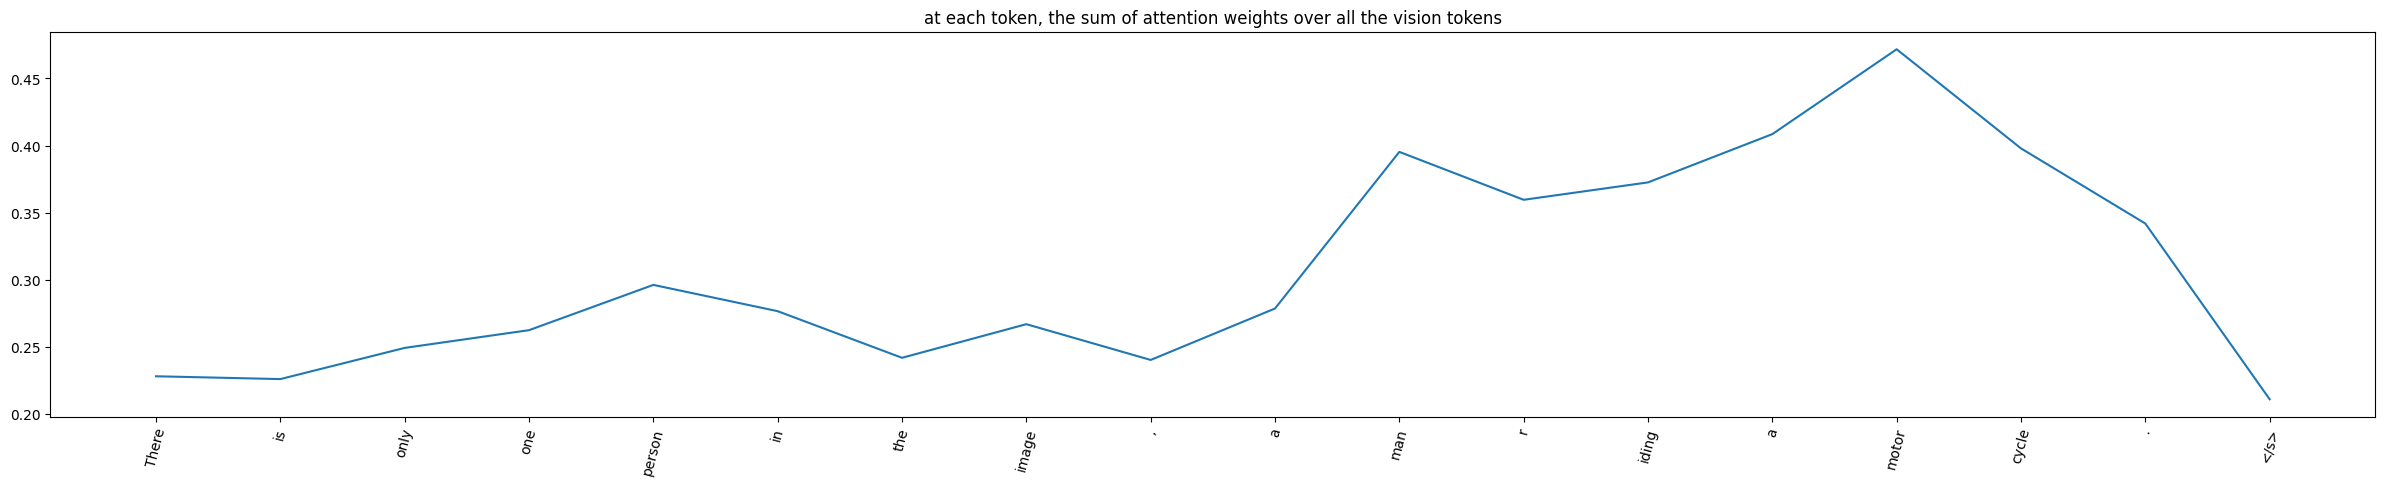

In [74]:
# look at the attention weights over the vision tokens
overall_attn_weights_over_vis_tokens = []
for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[input_token_len:], 
        output_sequences.tolist()
    )
):
    # print(
    #     i + input_token_len, 
    #     f"{tokenizer.decode(token, add_special_tokens=False).strip():<15}", 
    #     f"{row[vision_token_start:vision_token_end].sum().item():.4f}"
    # )

    overall_attn_weights_over_vis_tokens.append(
        row[vision_token_start:vision_token_end].sum().item()
    )

# plot the trend of attention weights over the vision tokens
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(overall_attn_weights_over_vis_tokens)
ax.set_xticks(range(len(overall_attn_weights_over_vis_tokens)))
ax.set_xticklabels(
    [tokenizer.decode(token, add_special_tokens=False).strip() for token in output_sequences.tolist()],
    rotation=75
)
ax.set_title("at each token, the sum of attention weights over all the vision tokens");

Below we aim to visualize the attention w.r.t. the input image. First we obtain a single attention map from the vision encoder (ViT) by again averaging the attention maps across heads and layers. I have tried a supposedly more reasonable method of [attention rollout](https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py), i.e. multiplying the attention matrices over each layer, but never got sensible results. See the `aggregate_vit_attention` in `utils.py` for details.


Then, for each generated token of LLM, we compute the weighted average of the attention map of each vision token to get an aggregated attention map over the input image for that generated token. Finally we resize and overlay the attention map on the input image.

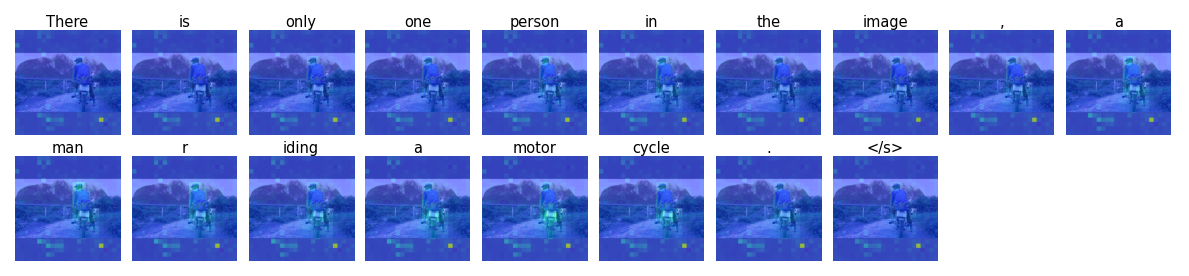

In [75]:
# connect with the vision encoder attention
# to visualize the attention over the image

# vis_attn_matrix will be of torch.Size([N, N])
# where N is the number of vision tokens/patches
# `all_prev_layers=True` will average attention from all layers until the selected layer
# otherwise only the selected layer's attention will be used
vis_attn_matrix = aggregate_vit_attention(
    model.get_vision_tower().image_attentions,
    select_layer=model.get_vision_tower().select_layer,
    all_prev_layers=True
)
grid_size = model.get_vision_tower().num_patches_per_side

num_image_per_row = 10
image_ratio = image_size[0] / image_size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)

fig, axes = plt.subplots(
    num_rows, num_image_per_row, 
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows), 
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or 
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

    attn_over_image = []
    for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
        vis_attn = vis_attn.reshape(grid_size, grid_size)
        # vis_attn = vis_attn / vis_attn.max()
        attn_over_image.append(vis_attn * weight)
    attn_over_image = torch.stack(attn_over_image).sum(dim=0)
    attn_over_image = attn_over_image / attn_over_image.max()

    attn_over_image = attn_over_image.to(torch.float32)

    attn_over_image = F.interpolate(
        attn_over_image.unsqueeze(0).unsqueeze(0), 
        size=image.size, 
        mode='nearest', 
        # mode='bicubic', align_corners=False
    ).squeeze()

    np_img = np.array(image)[:, :, ::-1]
    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
    ax.set_title(
        tokenizer.decode(output_sequences[i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off");